In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

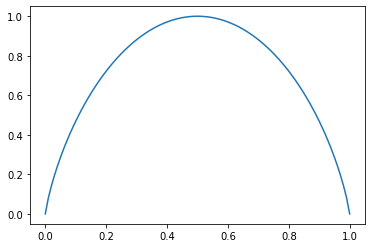

In [3]:
def entropy(pmf, epsilon=1e-4):
    try:
        pmf = np.array(pmf)
        mask = pmf>epsilon
        pmf = pmf[mask]  # 0log0 = 0
        return -1.0 * np.dot(pmf, np.log2(pmf))
    except TypeError as te:
        print(pmf, "is not iterable")

a = np.linspace(0, 1, 100)
b = np.zeros(a.shape)
for i, e in enumerate(a):
    b[i] = entropy([e, 1-e])
fig = plt.figure()
plt.plot(a, b)
plt.show()

def conditionalEntropy(cond_p, pmfs):
    assert len(cond_p) == len(pmfs)
    result = 0
    for i, p in enumerate(cond_p):
        result += p*entropy(pmfs[i, :])
    return result
    

def empiricalEntropy(label: pd.Series):
    pmf = label.value_counts().values / label.count()
    return entropy(pmf)

def empiricalConditionalEntropy(label: pd.Series, feature: pd.Series):
    assert label.count() == feature.count(), \
        "The length of label and feature should be the same when computing empirical conditional entropy"
    df = pd.DataFrame({'label':label, 'feature': feature})
    feature_values = feature.unique()  # get all distinct feature values
    result = 0
    for i, value in enumerate(feature_values):
        df_filtered = df.query('feature==@value')   # filter by feature value
        label_filtered = df_filtered['label']
        ee = empiricalEntropy(label_filtered)
        cond_p = feature.value_counts()[value]/feature.count()
        result += cond_p*ee
    return result

In [61]:
df = pd.DataFrame(np.random.randint(0, [4,2,3,3], size=(30, 4)), 
                columns=['attr0', 'attr1', 'attr2', 'attr3'])
ss = df['attr0']
pmf = ss.value_counts().values/ss.count()

empiricalEntropy(ss)

1.8556342202627085

In [121]:
df = pd.read_csv('./test_data.csv', delimiter='\t')
label = df['type']
empiricalEntropy(label)
empiricalConditionalEntropy(label=df['type'], feature=df['age'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['work'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['house'])
empiricalConditionalEntropy(label=df['type'], feature=df['credit'])

0.6079610319175832

In [128]:
np.delete(df.columns.values, -1)

array(['age', 'work', 'house', 'credit'], dtype=object)

In [4]:
class Node():
    def __init__(self, label, parent=None, children=[]):
        self.parent = parent
        self.children = children
        self.label = label  # test condition of each internal node is here
                            # list of str (used in pd.DataFrame.query)

    
class DecisionTree():
    def __init__(self, train_data: pd.DataFrame):
        """
            the last colum of train_data is the label
        """
        self.df = train_data
        self.features = np.delete(df.columns.values, -1) # get the features from all columns except the last one
        self.root_node = Node('root', parent=None, children=[])


    def grow(self, data:pd.DataFrame):
        if self.stopping_condition(data):
            # finnally we reach the leaf
            leaf = Node(None, parent=None, children=[])
            leaf.label = self.classify()
            return leaf
        else:
            root = Node(label=None)
            root.label, attr = self.find_best_split(data)
            for lb in root.label:
                assert type(lb) is str
                sub_data = data.query(lb)
                sub_data.drop(columns=[attr])  # this attribute has been used this time
                child = self.grow(sub_data)
                child.parent = root
                root.children.append(child)
        return root

    @staticmethod
    def check_discrete(data: pd.Series, epsilon=0.5):
        return ( 1.*data.nunique()/data.count() ) < epsilon

    def stopping_condition(self, data:pd.DataFrame, threshold=1e-4):
        assert len(data.columns.values) > 0, "Cannot find the label column"
        if len(data.columns.values) == 1:   # the last one column is the label of each sample
            # all attributes have been used, thus stop
            return True
        if len(data.columns.values) == 2:
            # the infomation gain of the only attribute is less than the threshold
            discrete = self.check_discrete(df.iloc[:, 0])
            if discrete:
                info_gain = empiricalEntropy(df.iloc[:, 0]) - \
                            empiricalConditionalEntropy(label=df.iloc[:, -1], feature=df.iloc[:, 0])
            else:
                raise ValueError("Continuous data is not available now")
            if info_gain < threshold:
                return True
        return False

    def find_best_split(self, data:pd.DataFrame):
        # select the attribute with largest information gain
        max_info_gain = -np.inf
        for col in data.columns:
            discrete = self.check_discrete(data[col])
            if discrete:
                info_gain = empiricalEntropy(df[col]) - \
                            empiricalConditionalEntropy(label=df.iloc[:, -1], feature=df[col])
            else:
                raise ValueError("Continuous data is not available now")
            # get largest info gain
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                attr_with_max_info_gain = col
                attr_discrete = discrete
        if attr_discrete:
            """
                for example, if available values for attr 'A' is [0, 1 ,2]
                then, cond = ['A==0', 'A==1', 'A==2']
            """
            cond = [attr_with_max_info_gain+'=='+str(i) for i in df[attr_with_max_info_gain].unique()]
        else:
            raise ValueError("Continuous data is not available now")
 
        return cond
        
        
    def classify(self, data:pd.DataFrame):
        pass

    

In [36]:
df = pd.read_csv('./test_data.csv', delimiter=',')
df

,age,work,house,credit,type,test
0,0.0,0.0,0.0,0.0,0.0,0.3
1,0.0,0.0,0.0,1.0,0.0,0.6
2,0.0,1.0,0.0,1.0,1.0,0.9
3,0.0,1.0,1.0,0.0,1.0,1.2
4,0.0,0.0,0.0,0.0,0.0,1.5
5,1.0,0.0,0.0,0.0,0.0,1.8
6,1.0,0.0,0.0,1.0,0.0,2.1
7,1.0,1.0,1.0,1.0,1.0,2.4
8,1.0,0.0,1.0,2.0,1.0,2.7
9,1.0,0.0,1.0,2.0,1.0,3.0


In [44]:
aa = df['credit']
col = 'credit'
cond = [col+'=='+str(i) for i in aa.unique()]
cond

['credit==0.0', 'credit==1.0', 'credit==2.0']

In [59]:
df = pd.DataFrame(np.random.randint(0, 10, [10,1]))
d = df.drop(columns=0)
len(d.columns.values) == 0

True

In [60]:
class A():
    def __init__(self):
        pass 
    def __call__(self, a):
        print(a)
dd = A()
dd(3)

3
